# Option-Implied Probability - Pt1
This script is inspired by https://reasonabledeviations.com/2020/10/01/option-implied-pdfs/

In [33]:
# Downloaded +/-50 from: https://www.barchart.com/futures/quotes/ZL*0/options?moneyness=20
import pandas as pd
raw_data = pd.read_csv('zlh23-options-american-options-exp-02_24_23-50-strikes-intraday-12-22-2022.csv')
commodity='Soybean Oil'
raw_data

,Strike,High,Low,Last,Change,Bid,Ask,Volume,Open Int,Premium,Last Trade
0,51.500C,13.450,13.450,13.450,0.010,12.540,12.760,NaN,NaN,8070.0,12/21/22
1,51.500P,0.180,0.180,0.180,-0.010,0.185,0.200,NaN,205.0,108.0,12/21/22
2,52.000C,12.970,12.970,12.970,0.005,12.070,12.285,NaN,NaN,7782.0,12/21/22
3,52.000P,0.210,0.210,0.210,0.010,0.210,0.225,1.0,132.0,126.0,11:03 CT
4,52.500C,12.495,12.495,12.495,0.005,11.600,11.815,NaN,1.0,7497.0,12/21/22
...,...,...,...,...,...,...,...,...,...,...,...
96,75.500C,0.490,0.490,0.490,-0.015,0.375,0.395,NaN,135.0,294.0,12/21/22
97,75.500P,11.105,11.105,11.105,-0.030,11.705,11.925,NaN,NaN,6663.0,12/21/22
98,76.000C,0.350,0.350,0.350,-0.100,0.340,0.360,15.0,397.0,210.0,11:32 CT
99,76.000P,11.560,11.560,11.560,-0.030,12.170,12.380,NaN,6.0,6936.0,12/21/22


In [34]:
# Assign Types, Normalize DF (Separate Columns)
def clean_options(df, remove_outliers=True, reduce=False, size=30):
    # Fix Types
    import numpy as np
    df = df.replace(np.nan,0)
    df.Volume = df.Volume.astype(int)
    df['Open Int'] = df['Open Int'].astype(int)

    # Separate Columns
    df['Strike Price'] = df.Strike.str.extract('(\d+\.\d+)').astype(float)
    df['Type'] = df.Strike.str[-1]
    df.Type = df.Type.replace({'C': 'Call', 'P': 'Put'})
    df = df.drop(['Strike'], axis=1)

    # Fix Date
    df['Last Trade'] = df['Last Trade'].str.replace('CT', '', regex=True)
    df['Last Trade'] = pd.to_datetime(df['Last Trade']).dt.tz_localize('America/Chicago')

    # Drop last row
    df = df.dropna()

    # Remove Outliers
    if remove_outliers:
            import warnings
            warnings.filterwarnings("ignore")
            df = df[df['Strike Price'] == df['Strike Price'].astype(int)]
            df.iloc[:,0] = df.iloc[:,0].apply(pd.to_numeric)

    # Filter to +/-30
    def reduce_scope(df, size=30):
        size=size/2
        mid_strike = df['Strike Price'].mean()
        l_range = mid_strike - size
        u_range = mid_strike + size
        df = df[df['Strike Price'].between(l_range, u_range)]
        return(df)
    if reduce:
        sbo = reduce_scope(df)

    return df[['Last Trade','Strike Price','Type','Last','Volume','Open Int','Premium']]

data = clean_options(raw_data)
#data

In [35]:
# Calculate probabilities from strike and price, then visualize p
def get_probs(df, strikes_name, prices_name, visualize=True):
    def visualize_pdf(strikes, probs):
        import matplotlib.pyplot as plt
        import matplotlib.ticker as mtick
        plt.rcParams.update({'font.size': 16, 'font.weight': 'bold', 'figure.figsize': (16,9)})

        fig, ax = plt.subplots(figsize=(16,9))
        ax.plot(strikes, probs)
        ax.set_title(f'{commodity} - {t} Option Implied Volatility',fontsize = 24)
        ax.set_xlabel('Strike Price')
        ax.set_ylabel('Probability In-The-Money')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.set_facecolor('#E6E6E6')
        plt.show()
        return()

    # Calculate probabilities and visualize PDF for Call and Put options
    for t in df.Type.unique():
        dfo=df[df.Type == t]
        strikes=dfo[strikes_name]
        prices=dfo[prices_name]

        # Window the df to have one strike per row, but the 3 prices near it for each butterfly
        import numpy as np
        strike, l_price, m_price, u_price = [], [], [], []
        for i in np.arange(0,len(strikes)):
            if (i>0) & (i<len(strikes)-1):
                l_price.append(prices.iloc[i-1])
                strike.append(strikes.iloc[i])
                m_price.append(prices.iloc[i])
                u_price.append(prices.iloc[i+1])
    
        # For each strike price, calculate the probability, p
        s, p = [], []
        for i in np.arange(0,len(strike)):
            sp = strike[i]
            lp = l_price[i]
            mp = m_price[i]
            up = u_price[i]

            # Calculate the probability a future expires at the target price
            prob = lp - (2 * mp) + up
            s.append(sp)
            p.append(prob)
        p = [i * 100 for i in p]

        # Visualize
        if visualize:
            visualize_pdf(s,p)

        # Define DF to concat
        probs = pd.DataFrame({'Strike Price': s,'Probability':p})
        probs=probs.dropna(axis=0)

        if t=='Call':
            c_probs = probs
        elif t=='Put':
            p_probs = probs
    
    # Merge Call and Put DFs
    c_probs['Type']='Call'
    p_probs['Type']='Put'
    data_probs = pd.concat([c_probs,p_probs], ignore_index=True)
    return(data_probs)

# Filter Call Strikes and Prices
data_probs = get_probs(data, 'Strike Price', 'Last', False)
#data_probs

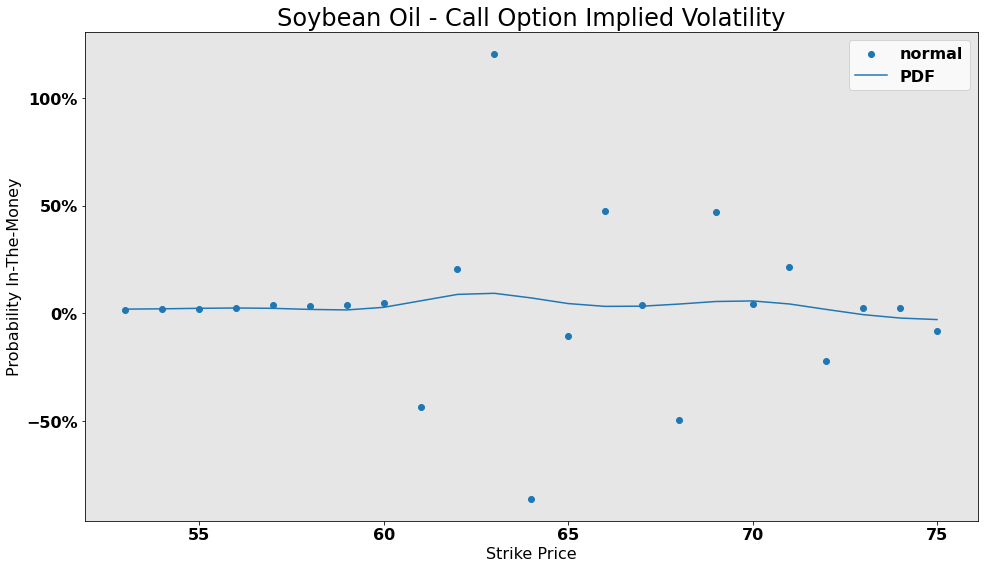

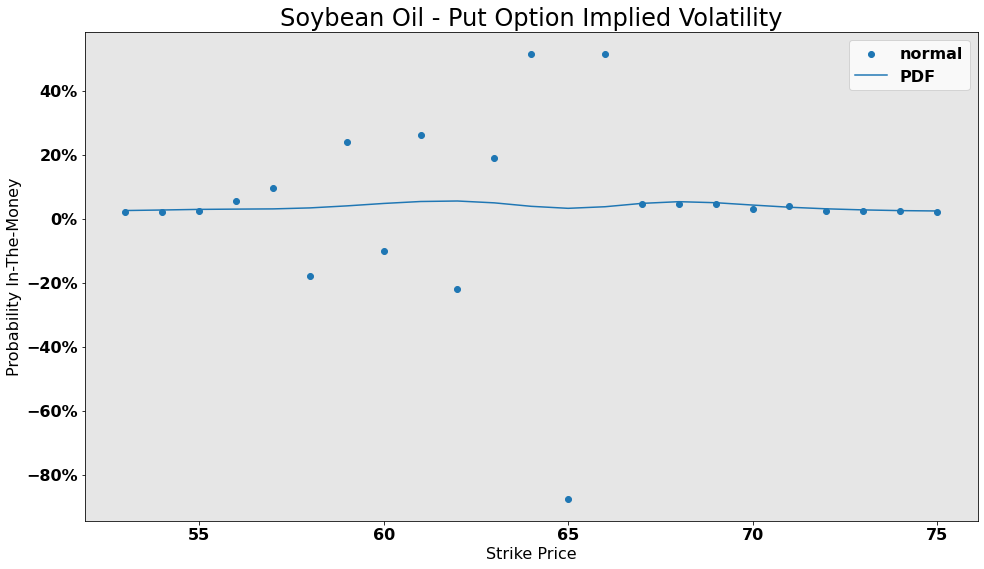

,Strike Price,Call Prob,Put Prob,Call PDF,Put PDF
0,53,1.5,2.0,1.949883,2.516534
1,54,2.0,2.0,2.097159,2.685882
2,55,2.0,2.5,2.331801,2.874730
3,56,2.5,5.5,2.486310,2.958492
4,57,4.0,9.5,2.326609,3.027863
5,58,3.5,0.0,1.815325,3.336860
6,59,4.0,24.0,1.577317,3.968525
7,60,5.0,0.0,2.790492,4.728829
8,61,0.0,26.0,5.790569,5.337780
9,62,20.5,0.0,8.787632,5.494505


In [36]:
# Calculate PDF from probs and visualize
def get_pdf(df, remove_outliers=True, derivatives=0):
    def visualize_pdf(strikes, probs, pdf):
        import matplotlib.pyplot as plt
        import matplotlib.ticker as mtick
        plt.rcParams.update({'font.size': 16, 'font.weight': 'bold', 'figure.figsize': (16,9)})

        fig, ax = plt.subplots(figsize=(16,9))
        ax.scatter(strikes, probs, marker='o', label='normal')
        ax.plot(x, pdf, label='PDF')
        ax.set_title(f'{commodity} - {t} Option Implied Volatility',fontsize = 24)
        ax.set_xlabel('Strike Price')
        ax.set_ylabel('Probability In-The-Money')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.set_facecolor('#E6E6E6')
        plt.legend()
        plt.show()

    # Calcuate for Call and/or Put
    for t in df.Type.unique():
        dfo = df[df.Type == t]

        # Smooth with Gaussian Filter
        from scipy import ndimage as nd
        x = dfo['Strike Price']
        y = dfo['Probability']
        sigma=2
        pdf = nd.gaussian_filter1d(y, sigma)

        # Plot
        visualize_pdf(x, y, pdf)

        # Save
        if t=='Call':
            c_pdf = pd.Series(pdf)
            c_y = pd.Series(y)
            c_pdf.reset_index(drop=True, inplace=True)
            c_y.reset_index(drop=True, inplace=True)
        elif t=='Put':
            p_pdf = pd.Series(pdf)
            p_y = pd.Series(y)
            p_pdf.reset_index(drop=True, inplace=True)
            p_y.reset_index(drop=True, inplace=True)
    x = pd.Series(x)
    x.reset_index(inplace=True,drop=True)
    df = pd.DataFrame({'Strike Price':x.values.astype(int), 'Call Prob':c_y.values.round(decimals = 2), 'Put Prob':p_y.values.round(decimals = 2), 'Call PDF':c_pdf.values, 'Put PDF':p_pdf.values})

    # Replace negative values with 0
    for k, v in df.iteritems():
        v[v < 0] = 0
    return(df)

data_pdf = get_pdf(data_probs, True)
data_pdf

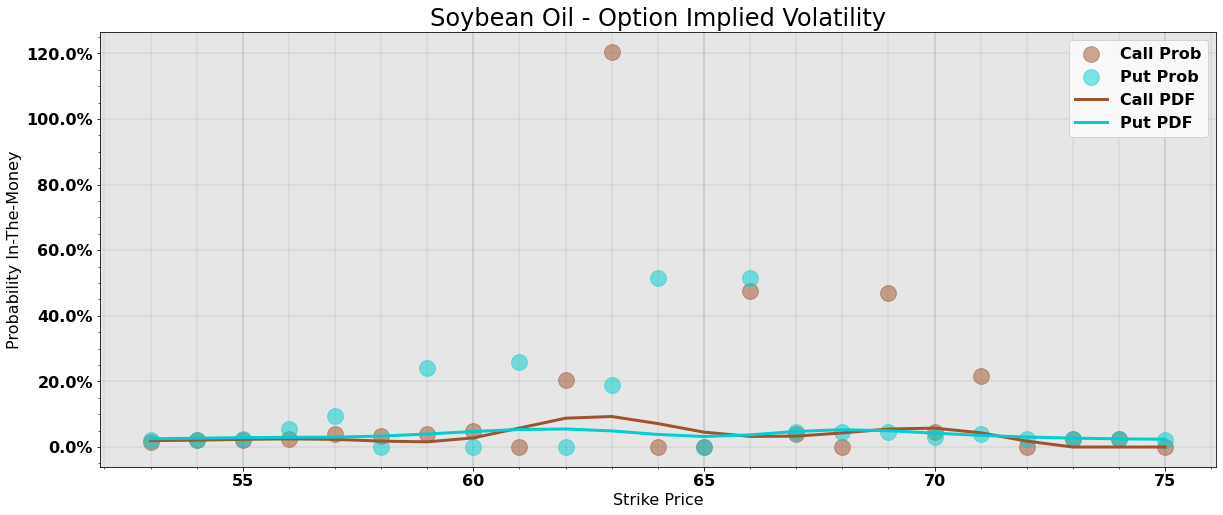

In [37]:
def plot_all(strike, c_p, c_pdf, p_p, p_pdf):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    plt.rcParams.update({'font.size': 16, 'font.weight': 'bold'})

    fig, ax = plt.subplots(figsize=(20,8))
    ax.scatter(strike, c_p, color='sienna', s=250, marker='o', alpha=.5, label='Call Prob')
    ax.scatter(strike, p_p, color='darkturquoise', s=250, marker='o', alpha=.5, label='Put Prob')
    ax.plot(strike, c_pdf, color='sienna', linewidth=3, label='Call PDF')
    ax.plot(strike, p_pdf, color='darkturquoise', linewidth=3, label='Put PDF')
    ax.set_title(f'{commodity} - Option Implied Volatility',fontsize = 24)
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Probability In-The-Money')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
    ax.set_xticks(ticks=strike.unique(), minor=True)
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(axis='x', which='minor', linestyle='-', linewidth='0.2', color='slategray')
    ax.grid(axis='x', which='major', linestyle='-', linewidth='0.3', color='darkslategray')
    ax.grid(axis='y', which='major', linestyle='-', linewidth='0.2', color='slategray')
    ax.set_facecolor('#E6E6E6')
    ax.legend()
    figure = plt.gcf()
    return(figure)

fig = plot_all(data_pdf['Strike Price'], data_pdf['Call Prob'], data_pdf['Call PDF'], data_pdf['Put Prob'], data_pdf['Put PDF'])


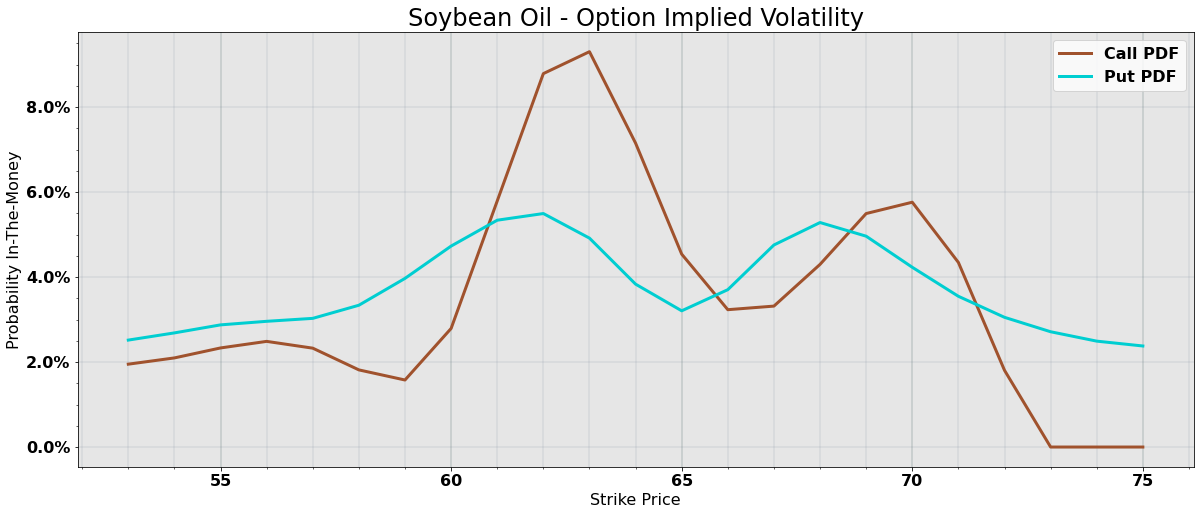

In [38]:
def plot_all(strike, c_pdf, p_pdf):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    plt.rcParams.update({'font.size': 16, 'font.weight': 'bold'})

    fig, ax = plt.subplots(figsize=(20,8))
    ax.plot(strike, c_pdf, color='sienna', linewidth=3, label='Call PDF')
    ax.plot(strike, p_pdf, color='darkturquoise', linewidth=3, label='Put PDF')
    ax.set_title(f'{commodity} - Option Implied Volatility',fontsize = 24)
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Probability In-The-Money')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
    ax.set_xticks(ticks=strike.unique(), minor=True)
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(axis='x', which='minor', linestyle='-', linewidth='0.2', color='slategray')
    ax.grid(axis='x', which='major', linestyle='-', linewidth='0.3', color='darkslategray')
    ax.grid(axis='y', which='major', linestyle='-', linewidth='0.2', color='slategray')
    ax.set_facecolor('#E6E6E6')
    ax.legend()
    figure = plt.gcf()
    return(figure)

fig = plot_all(data_pdf['Strike Price'], data_pdf['Call PDF'], data_pdf['Put PDF'])

In [39]:
!datapane login --token=856743ad2e8cd913c6816ea39a222057b9da5d6e

Connected successfully to https://cloud.datapane.com as mac13faldet@gmail.com


In [40]:
import datapane as dp

app = dp.Report(                               # This initiates the report
    dp.Text(f"# {commodity} PDF"),             # Adding Text
    dp.Text("## Option Implied Probability - pt1"),
    dp.Text("""Probabilities approximated with hitting the strike is full payoff, different price pays 0."""),
    dp.Plot(fig),                           # Adding a Plot
    dp.Text(f"#### PDF of {commodity}"),
    dp.DataTable(data_pdf))

app.upload(name=f"Report: {commodity} Options Implied PDF - pt1", open=True)
app.save(path="SBO_PDF_pt1.html")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\macfa\\AppData\\Local\\Temp\\dp-tmp-iusxya8f\\dp-tmp-i06dtu4j.svg'